## Using Twitter Data to Measure Inflation Expectations and Consumers’ Economic Confidence During the COVID Era

#### Author: Deji Suolang

This project intends to explore whether and how Twitter data convey people’s beliefs about price dynamics, inflation expectations and consumers’ economic confidence, as well as how they change over time in the past three years. Data mining techniques such as frequent N-grams, sentiment analysis, time series analysis, and regression models are applied to 1.4 million tweets generated between November 2019 to November 2022. The estimates from Twitter data are then compared to analogous monthly index in Survey of Consumers to see how social media align with nationally representative surveys. The results indicate that price, living cost, interest rate are main topic people tweeted, and concerns are associated with increasing price of food, gas, rent and electricity. Consumers’ economic confidence reflected by Twitter is useful for evaluating overall trend and direction of the changes, but not quite accurate when comes to measuring the magnitude of the changes. There not seem to be any seasonal pattern. Twitter-based price change expectation index is echoing the survey index, and prediction for the next year is made based on the polynomial regression models. This project conclude that tweet-based estimate can potentially be a much cheaper and timelier alternative data source to measure inflation expectations and consumers’ economic confidence, but there is more future work needed to address the representation errors of such found data.

Keywords: Twitter, surveys, data mining, inflations, sentiment analysis


The project use two data sources:
1. 1.4 million tweets that obtained through scraping, time window covers from November 2019 to November 2022. Scraped Twitter data are saved as JSON file:
https://drive.google.com/drive/u/0/folders/1jh-nn6WQJ8IrBvRPo82F_3oBZ9FStZlo
2. Survey of Consumers, monthly index from November 2019 to November 2022 are saved as csv files: https://drive.google.com/drive/u/0/folders/1gb3gaYcRDmlglZ2r50wNrTcrNxuA_Cm7

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import warnings
warnings.filterwarnings('ignore') # setting ignore as a parameter
#%pip install snscrape
#%pip install langdetect
#%pip install git+https://github.com/JustAnotherArchivist/snscrape.git
import snscrape.modules.twitter as sntwitter
import json
from langdetect import detect
import datetime
from datetime import date, timedelta
#%pip install emoji
import emoji
import nltk
nltk.download('words')
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize
from nltk.collocations import *
import re
import seaborn as sns
from collections import Counter
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from itertools import chain
#%pip install textblob
from textblob import TextBlob
#%pip install statsmodels --upgrade
from statsmodels.tsa.seasonal import seasonal_decompose, DecomposeResult
import matplotlib.dates as mdates
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

[nltk_data] Downloading package words to /Users/dsuolang/nltk_data...
[nltk_data]   Package words is already up-to-date!


## 1. Data Collection
### 1.1 Twitter Data Scraping

In [2]:
# I have four sets of keywords that are corresponding to the differnt research questions
inflation_keywords =['inflation', 'inflate', 'inflated']
expectation_keywords =['prices will increase', 'prices will drop',  'prices will go up', 'prices will go down',
                       'price will drop', 'price will increase',  'price will go down', 'price will go up',
                       'price will cheaper','price will higher','prices will cheaper','prices will higher', # I ignored the 'be' intentionally
                       'will cost more', 'will cost less', 'inflation will continue', 'inflation will end']
economics_keywords =['economics','consumers','saving', 'spending','savings', 'spending','spendings','living costs']
purchase_keywords = ['food prices' 'gas prices','food price','gas price','purchase' 'purchase home','purcahse car','rent']
overall_keywords= inflation_keywords + expectation_keywords + economics_keywords + purchase_keywords
keywords_list =[inflation_keywords,expectation_keywords,economics_keywords,purchase_keywords]

# Save scarping results into four json files
inflation_tweet = 'inflation_tweet.json'
expectation_tweet = 'expectation_tweet.json'
economics_tweet = 'economics_tweet.json'
purchase_tweet = 'purchase_tweet.json'
categories = ["inflation", "expectation", "economics", "purchase"]

In [3]:
inflation_df = pd.DataFrame([json.loads(line) for line in open('inflation_tweet.json', 'r')])
expectation_df = pd.DataFrame([json.loads(line) for line in open('expectation_tweet.json', 'r')])
economics_df = pd.DataFrame([json.loads(line) for line in open('economics_tweet.json', 'r')])
purchase_df= pd.DataFrame([json.loads(line) for line in open('purchase_tweet.json', 'r')])

### 1.2 Survey of Consumer Index

In [4]:
consumer_sentiment_index = pd.read_csv('consumer_sentiment.csv')
price_expchange_index = pd.read_csv('price_expchange.csv')
consumer_expectation_index = pd.read_csv('consumer_expectation.csv')

## 2. Exploratary Analysis

In [5]:
def clean_tweet(tweet):
    """Clean tweet by by removeing stopwords, url and special characters

    Parameters
    ----------
    original tweet text

    Returns
    -------
    Cleaned tweet text
    """
    stop_words = set(stopwords.words('english'))
    stop_words.update(["https", "think", "this","that","will", "say",'y','s','t','co','dont','I','us','aoc','one','would','thats','im','98','99','0'])
    #stop_words.update(keywords)
    tweet = re.sub("@[A-Za-z0-9]+","",tweet) #Remove @ sign
    tweet = re.sub(r"(?:\@|http?\://|https?\://|www)\S+", "", tweet) #Remove http links
    tweet = re.sub(r'[^\w\s]+', '',tweet)
    tweet = re.sub(r"([^0-9A-Za-z \t])|(\w+:\/\/\S+)", "",tweet)
    tweet = " ".join(tweet.split())
    tweet = ''.join(c for c in tweet if c not in emoji.EMOJI_DATA) #Remove Emojis
    tweet = tweet.replace("#", "").replace("_", " ") #Remove hashtag sign but keep the text
    tweet = " ".join(w for w in nltk.wordpunct_tokenize(tweet) 
                     if w.lower() not in stop_words)
    return tweet
    
def wordcloud(df):
    wordcloud = WordCloud(width = 1000, height = 500,background_color="white").generate(' '.join(df['clean_text']))
    plt.figure(figsize=(15,8))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()
    plt.close()
    
def find_ngrams(input_list, n):
    return list(zip(*[input_list[i:] for i in range(n)]))

def common_2gram(df, n_common): # Bigram Frequency Counts
    df['bigrams'] = df['clean_text'].map(lambda x: find_ngrams(x.split(" "), 2))
    bigrams = df['bigrams'].tolist()
    bigrams = list(chain(*bigrams))
    bigrams = [(x.lower(), y.lower()) for x,y in bigrams]
    bigram_counts = Counter(bigrams)
    return bigram_counts.most_common(n_common)

def plot_2gram(df, n_common, title, color):
    ngram_df = pd.DataFrame(common_2gram(df, n_common),columns=['Ngram', 'Count'])
    ngram_df.plot.barh(rot=0, figsize=(5,3), width=0.8, x = 'Ngram', y='Count',title=title, color=color)
    plt.title = title

def common_3gram(df, n_common):# Trigram Frequency Counts
    df['trigrams'] = df['clean_text'].map(lambda x: find_ngrams(x.split(" "), 3))
    trigrams = df['trigrams'].tolist()
    trigrams= list(chain(*trigrams))
    trigrams = [(x.lower(), y.lower(), z.lower()) for x,y,z in trigrams]
    trigrams_counts = Counter(trigrams)
    return trigrams_counts.most_common(n_common)

def plot_3gram(df, n_common, title, color):
    ngram_df = pd.DataFrame(common_3gram(df, n_common),columns=['Ngram', 'Count'])
    ngram_df.plot.barh(rot=0, figsize=(5,3), width=0.8, x = 'Ngram', y='Count',title=title,color=color)

In [6]:
# Examine how many tweet in total in the scraped file
df_list = [inflation_df,expectation_df,economics_df,purchase_df]
i = 0
sum_num = 0
for df in df_list:
    print("Number of tweets related to {}: {:,}".format(categories[i], len(df.index)))
    sum_num += len(df.index)
    i += 1
print("Total number of tweets in this study: {:,}".format(sum_num))

Number of tweets related to inflation: 321,489
Number of tweets related to expectation: 1,308,647
Number of tweets related to economics: 792,332
Number of tweets related to purchase: 422,572
Total number of tweets in this study: 2,845,040


In [7]:
#There are more than 2.8 million tweets, we will randomly sample 50% of them for the analysis by selecting every other tweet.
inflation_df = inflation_df.iloc[::2, :]
expectation_df = expectation_df.iloc[::2, :]
economics_df = economics_df.iloc[::2, :]
purchase_df = purchase_df.iloc[::2, :]

In [8]:
# Examine again how many tweet in total in the scraped file
df_list = [inflation_df,expectation_df,economics_df,purchase_df]
i = 0
sum_num = 0
for df in df_list:
    print("Number of tweets related to {}: {:,}".format(categories[i], len(df.index)))
    sum_num += len(df.index)
    i += 1
print("Total number of tweets in this study: {:,}".format(sum_num))

Number of tweets related to inflation: 160,745
Number of tweets related to expectation: 654,324
Number of tweets related to economics: 396,166
Number of tweets related to purchase: 211,286
Total number of tweets in this study: 1,422,521


In [9]:
# Clean tweet text
inflation_df['clean_text'] = inflation_df['text'].map(lambda x: clean_tweet(x))
expectation_df['clean_text'] = expectation_df['text'].map(lambda x: clean_tweet(x))
economics_df['clean_text'] = economics_df['text'].map(lambda x: clean_tweet(x))
purchase_df['clean_text'] = purchase_df['text'].map(lambda x: clean_tweet(x))
df_list = [inflation_df,expectation_df,economics_df,purchase_df]

overall_df = inflation_df.append(expectation_df)
overall_df = overall_df.append(economics_df)
overall_df = overall_df.append(purchase_df)

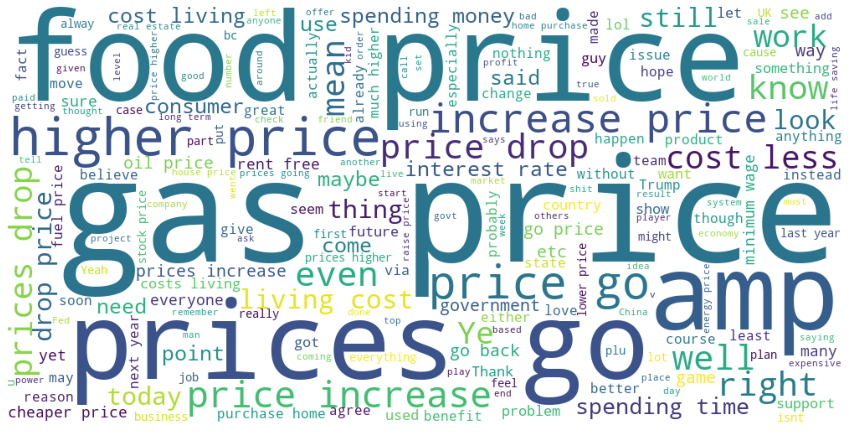

In [10]:
# word cloud based on all tweets
wordcloud(overall_df)

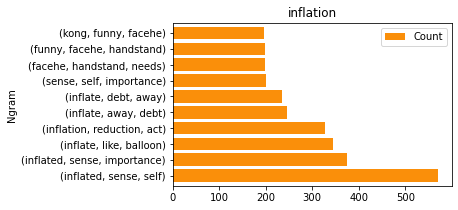

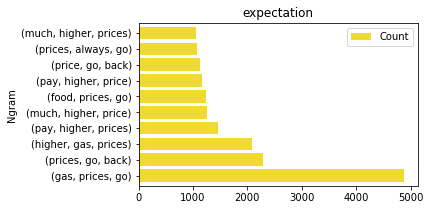

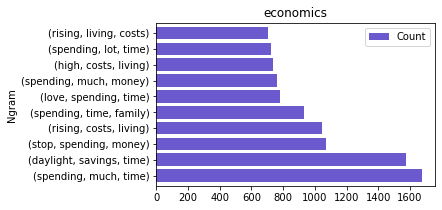

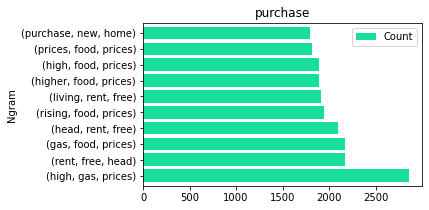

In [11]:
# most frequent Ngram for tweets in each categories
i=0
colors = ['#FA8F0A','#F0DA32','slateblue','#18DE9D']
for i in range(0,4):
    plot_3gram(df_list[i], 10, categories[i], colors[i])
    i +=1

## 3. Sentiment Analysis and Time Series Pattern

In [12]:
def sentiment_classifier_five(tweet):
    analysis = TextBlob(tweet)
    if (analysis.sentiment.polarity == 0):  
        return 'netural'
    elif (analysis.sentiment.polarity > 0 and analysis.sentiment.polarity <= 0.5):
        return 'somewhat positive'
    elif (analysis.sentiment.polarity > 0.5 and analysis.sentiment.polarity <= 1):
        return 'positive'
    elif (analysis.sentiment.polarity > -0.5 and analysis.sentiment.polarity <= 0):
        return 'somewhat negative'
    elif (analysis.sentiment.polarity > -1 and analysis.sentiment.polarity <= -0.5):
        return 'negative'
    
def sentiment_classifier_three(tweet):
    analysis = TextBlob(tweet)
    if (analysis.sentiment.polarity == 0):  
        return 'netural'
    elif (analysis.sentiment.polarity > 0 and analysis.sentiment.polarity <= 1):
        return 'positive'
    elif (analysis.sentiment.polarity >= -1 and analysis.sentiment.polarity < 0):
        return 'negative'
    
def df_to_timeseries(df):
    """Convert the dataframe to the series that is ready for time series analysis

    Parameters
    ----------
    dataframe

    Returns
    -------
    python series that is ready for time series analysis
    """
    df['date'] = pd.to_datetime(df['date']).dt.date
    df['sentiment_c5'] = df['clean_text'].map(lambda x: sentiment_classifier_five(x))
    df['sentiment_c3'] = df['clean_text'].map(lambda x: sentiment_classifier_three(x))
    df_timeseries = df[['date','sentiment_c3']].groupby(['sentiment_c3','date']).size().reset_index()
    df_timeseries = df_timeseries.rename(columns={0: "count"})
    #df_timeseries['count'] = np.log(df_timeseries['count'])
    df_timeseries = pd.pivot(df_timeseries, index=['sentiment_c3'], columns = 'date',values = 'count') #Reshape from long to wide
    return df_timeseries

def pie_chart(df):
    label=df.sentiment_c5.value_counts().index
    count=df.sentiment_c5.value_counts().values
    plt.pie(count, labels=label, colors=['#FA8F0A','#F0DA32','slateblue','#61F527','#18DE9D'], autopct='%1.1f%%')
    plt.show()

    
def seasonal_decomp(series, sentiment):
    """Convert the dataframe to the series that is ready for time series analysis
    """
    # apply seasonal decomposition function to data with 'additive' model
    series = (series.loc[sentiment])
    sea_decomp = seasonal_decompose(series, model="additive",extrapolate_trend='freq', period=12) # Each quarter, 12 quarters in 3 years
    sea_decomp
    # plot
    fig, axes = plt.subplots(2, 1, figsize=(10, 6), sharex=True)
    month_year_formatter = mdates.DateFormatter('%b, %Y')
    half_year_locator = mdates.MonthLocator(interval=6)
    monthly_locator = mdates.MonthLocator()

    axes[0].xaxis.set_major_locator(half_year_locator)
    axes[0].xaxis.set_minor_locator(monthly_locator)
    axes[0].xaxis.set_major_formatter(month_year_formatter)
    axes[0].plot(sea_decomp.seasonal)
    axes[0].set_ylabel("Seasonal") # seasonality component 
    
    axes[1].xaxis.set_major_locator(half_year_locator)
    axes[1].xaxis.set_minor_locator(monthly_locator)
    axes[1].xaxis.set_major_formatter(month_year_formatter)
    axes[1].plot(sea_decomp.resid) #  time series with the trend and seasonal components removed
    axes[1].set_ylabel("Residual")
    
    #axes[1].set_xlabel("Time")
    fig.suptitle("Number of {} Tweets Over Time".format(sentiment.capitalize()), x=0.513, y=0.95)
                 
def wma_plot(series, wd_size, sentiment1, sentiment2):
    series1 = (series.loc[sentiment1])
    series2 = (series.loc[sentiment2])
    weights = np.arange(1, wd_size + 1).astype(float) # linear weighting
    wma1 = []
    for i in range(len(series1)): # loop through case counts
        low, high = max(0, i - wd_size + 1), i + 1 # get current window
        wma1.append(np.average(series1.iloc[low: high], weights=weights[-(high - low):])) # compute average
    wma2 = []
    for i in range(len(series2)): # loop through case counts
        low, high = max(0, i - wd_size + 1), i + 1 # get current window
        wma2.append(np.average(series2.iloc[low: high], weights=weights[-(high - low):])) # compute average
    wma1 = np.array(wma1) # convert to an array
    wma2 = np.array(wma2) # convert to an array
    # plot
    fig, ax = plt.subplots(figsize=(10, 6))
    month_year_formatter = mdates.DateFormatter('%b, %Y')
    half_year_locator = mdates.MonthLocator(interval=6)
    monthly_locator = mdates.MonthLocator()
    ax.xaxis.set_major_locator(half_year_locator)
    ax.xaxis.set_minor_locator(monthly_locator)
    ax.xaxis.set_major_formatter(month_year_formatter)
    ax.plot(series1.index, series1.values, label = "Positive_Original")
    ax.plot(series1.index, wma1, label = "Positive_WMA")
    ax.plot(series2.index, series2.values, label = "Negative_Original")
    ax.plot(series2.index, wma2, label = "Negative_WMA")
    #ax.set_xlabel("Time")
    ax.set_ylabel("Number of Tweets")
    ax.set_title("Number of Postive/Negative Tweets Over Time")
    ax.legend()
    
def survey_index_plot(df, title):
    fig, ax = plt.subplots(figsize=(10, 6))
    df['Date'] = pd.to_datetime(df['Date']).dt.date
    month_year_formatter = mdates.DateFormatter('%b, %Y')
    half_year_locator = mdates.MonthLocator(interval=6)
    monthly_locator = mdates.MonthLocator()
    ax.xaxis.set_major_locator(half_year_locator)
    ax.xaxis.set_minor_locator(monthly_locator)
    ax.xaxis.set_major_formatter(month_year_formatter)
    ax.plot(df.Date, df.Monthly, label = "Monthly Original")
    ax.plot(df.Date, df.Monthly_MA, label = "Monthly Moving Average")
    ax.set_title("{} Index from Surveys of Consumers".format(title))
    ax.legend()

### 3.1 What are the consumers’ perceptions toward the inflation?

In [13]:
# Convert the dataframe to the series that is ready for time series analysis
inflation_series = df_to_timeseries(inflation_df)
inflation_series

date,2019-11-01,2019-11-02,2019-11-03,2019-11-04,2019-11-05,2019-11-06,2019-11-07,2019-11-08,2019-11-09,2019-11-10,...,2022-10-23,2022-10-24,2022-10-25,2022-10-26,2022-10-27,2022-10-28,2022-10-29,2022-10-30,2022-10-31,2022-11-01
sentiment_c3,,,,,,,,,,,,,,,,,,,,,
negative,41,29,47,31,47,51,49,37,39,49,...,44,38,47,42,39,40,34,38,44,43
netural,48,43,43,42,41,37,43,40,33,26,...,52,42,47,41,39,44,44,43,33,41
positive,57,70,57,77,56,59,54,69,73,72,...,52,68,54,67,71,62,70,68,70,66


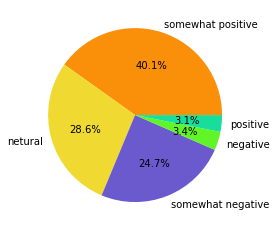

In [14]:
# Visualize the sentiment classfication for tweets regarding inflation
pie_chart(inflation_df)

Calculating a Weighted Moving Average (WMA). The regression method seems to give a fairly accurate description of the trend hidden in the time series. In this section and the next, we will explore an alternatiseasonal_decomp(inflation_series, 'positive')
seasonal_decomp(inflation_series, 'negative')ve method for discovering trends that is based on moving averages.

To each data point $x_{j}$:

\begin{align}
x_{j}^{\prime} &=
\frac{w_{k}x_{j} + w_{k - 1}x_{j - 1} + \cdots + w_{1}x_{j - k + 1}}{w_{k} + w_{k - 1} + \cdots + w_{1}} & \text{if } j > k \\ \\
x_{j}^{\prime} &= \frac{w_{k}x_{j} + w_{k - 1}x_{j - 1} + \cdots + w_{k - j + 1}x_{1}}{w_{k} + w_{k - 1} + \cdots + w_{k - j + 1}} & \text{if } j \leq k
\end{align}

for a window of size $k$. In the code below, we will calculate the WMA for our input time series. 

In [15]:
inflation_series

date,2019-11-01,2019-11-02,2019-11-03,2019-11-04,2019-11-05,2019-11-06,2019-11-07,2019-11-08,2019-11-09,2019-11-10,...,2022-10-23,2022-10-24,2022-10-25,2022-10-26,2022-10-27,2022-10-28,2022-10-29,2022-10-30,2022-10-31,2022-11-01
sentiment_c3,,,,,,,,,,,,,,,,,,,,,
negative,41,29,47,31,47,51,49,37,39,49,...,44,38,47,42,39,40,34,38,44,43
netural,48,43,43,42,41,37,43,40,33,26,...,52,42,47,41,39,44,44,43,33,41
positive,57,70,57,77,56,59,54,69,73,72,...,52,68,54,67,71,62,70,68,70,66


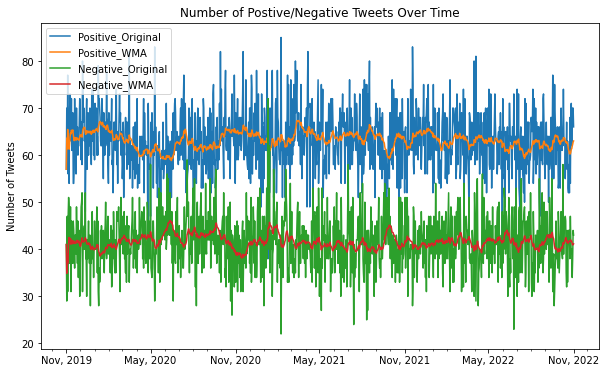

In [16]:
wma_plot(series = inflation_series, wd_size = 30, sentiment1 = 'positive', sentiment2 = 'negative')

Perform a Seasonal Decomposition, this is to get a sense of what possible patterns are hidden in the data using an additive model.

\begin{equation*}
Y(t) = T(t) + S(t) + R(t)
\end{equation*}

where $T(t)$ represents trends, $S(t)$ represents seasonal patterns and $R(t)$ represents residuals.

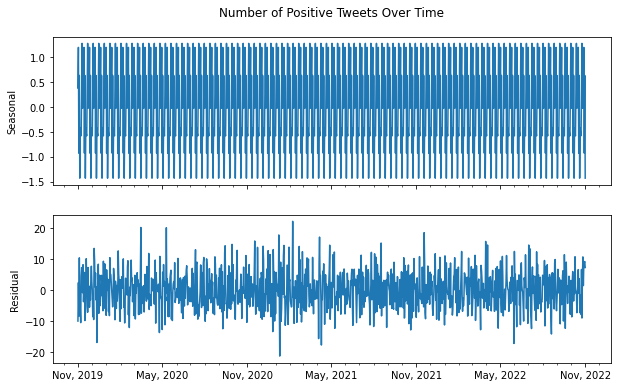

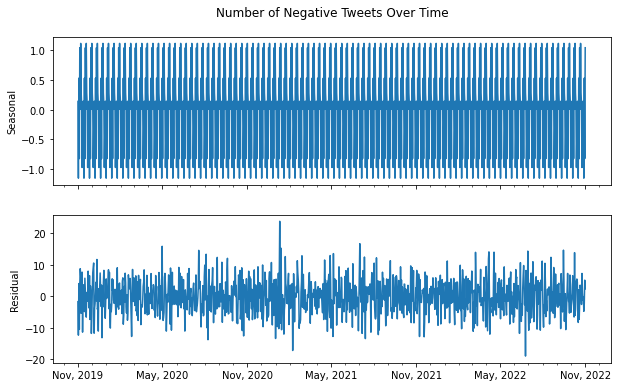

In [17]:
seasonal_decomp(inflation_series, 'positive')
seasonal_decomp(inflation_series, 'negative')

### 3.2 What are the consumers’sentiments about purchasing and the price?

In [18]:
# Convert the dataframe to the series that is ready for time series analysis
purchase_series = df_to_timeseries(purchase_df)
purchase_series

date,2019-11-01,2019-11-02,2019-11-03,2019-11-04,2019-11-05,2019-11-06,2019-11-07,2019-11-08,2019-11-09,2019-11-10,...,2022-10-23,2022-10-24,2022-10-25,2022-10-26,2022-10-27,2022-10-28,2022-10-29,2022-10-30,2022-10-31,2022-11-01
sentiment_c3,,,,,,,,,,,,,,,,,,,,,
negative,24,32,44,41,38,34,27,39,27,31,...,53,54,38,40,45,45,47,37,45,45
netural,49,55,30,46,48,53,57,39,58,46,...,45,41,57,63,40,45,41,49,66,52
positive,111,87,93,86,92,91,107,110,94,88,...,100,102,99,92,112,104,106,109,86,99


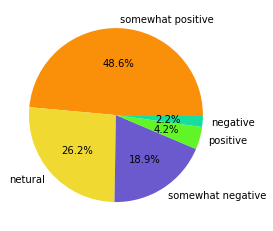

In [19]:
# Visualize the sentiment classfication for tweets regarding purchasing and the price
pie_chart(purchase_df)

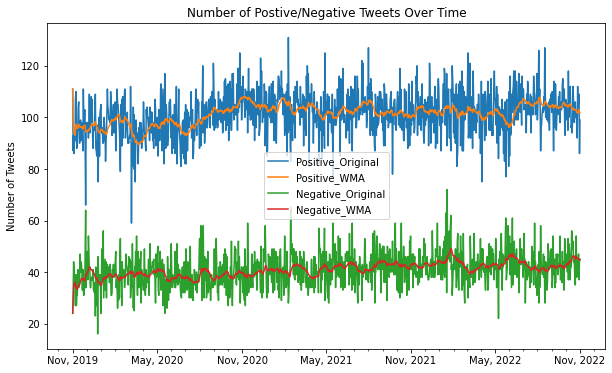

In [20]:
#Calculating a Weighted Moving Average and plot
wma_plot(series = purchase_series, wd_size = 30, sentiment1 = 'positive', sentiment2 = 'negative')

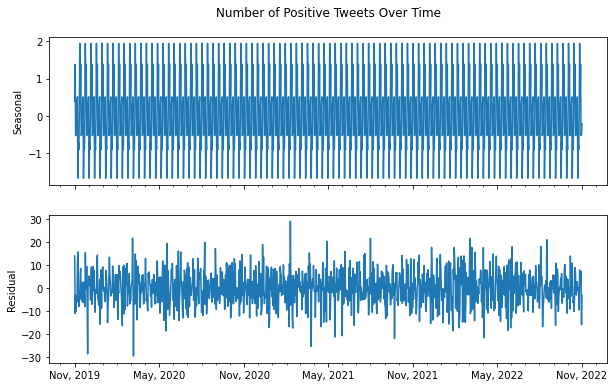

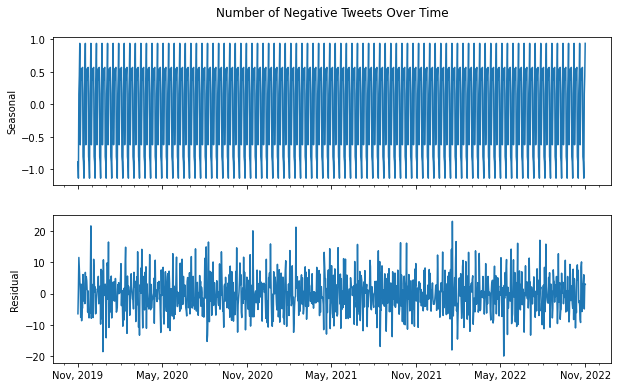

In [21]:
#seasonal decomposition
seasonal_decomp(purchase_series, 'positive')
seasonal_decomp(purchase_series, 'negative')

### 3.3 What are the consumers’ confidence/sentiments regarding the economics?

In [22]:
# Convert the dataframe to the series that is ready for time series analysis
economics_series = df_to_timeseries(economics_df)
economics_series

date,2019-11-01,2019-11-02,2019-11-03,2019-11-04,2019-11-05,2019-11-06,2019-11-07,2019-11-08,2019-11-09,2019-11-10,...,2022-10-23,2022-10-24,2022-10-25,2022-10-26,2022-10-27,2022-10-28,2022-10-29,2022-10-30,2022-10-31,2022-11-01
sentiment_c3,,,,,,,,,,,,,,,,,,,,,
negative,85,73,94,91,85,78,87,76,76,76,...,98,92,88,80,100,83,103,84,93,80
netural,103,108,93,101,105,125,98,102,103,119,...,116,117,115,128,111,118,104,110,117,117
positive,170,171,164,181,169,153,175,183,215,182,...,154,170,178,170,164,172,160,172,179,181


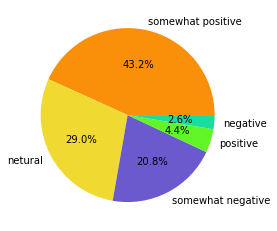

In [23]:
# Visualize the sentiment classfication for tweets regarding purchasing and the price
pie_chart(economics_df)

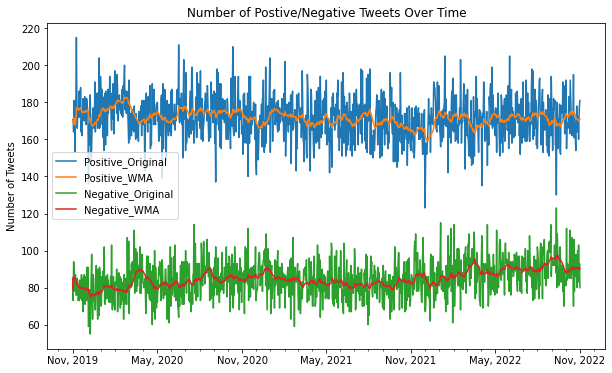

In [24]:
#Calculating a Weighted Moving Average and plot
wma_plot(series = economics_series, wd_size = 30, sentiment1 = 'positive', sentiment2 = 'negative')

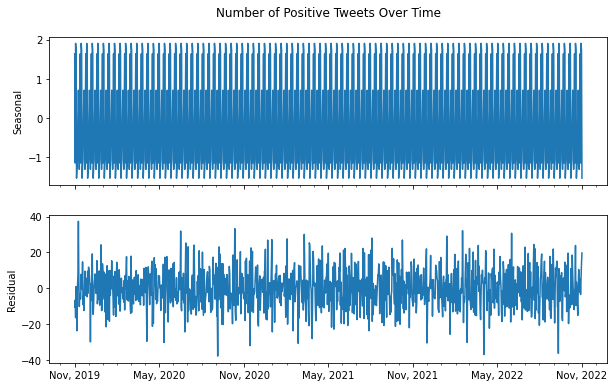

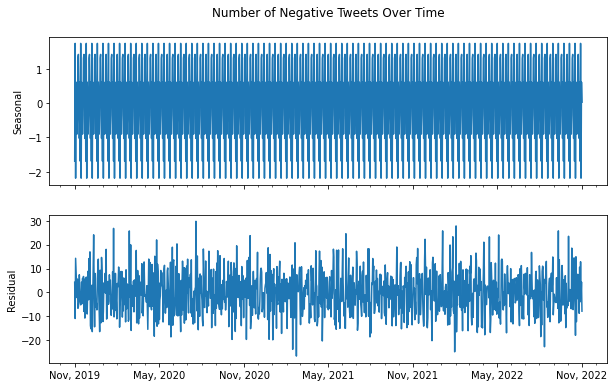

In [25]:
#seasonal decomposition
seasonal_decomp(economics_series, 'positive')
seasonal_decomp(economics_series, 'negative')

In [26]:
# Consumer economic expectation index from nationally representative surveys: Surveys of Consumers 
consumer_expectation_index.head()

,Date,Monthly,Monthly_MA
0,11/1/19,87.3,85.0
1,12/1/19,88.9,86.8
2,1/1/20,90.5,88.9
3,2/1/20,92.1,90.5
4,3/1/20,79.7,87.4


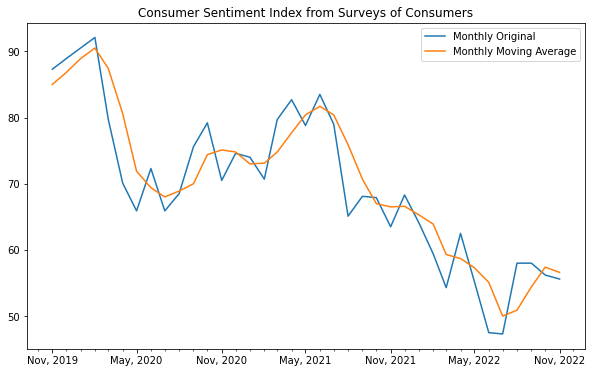

In [27]:
# plot
survey_index_plot(consumer_expectation_index, "Consumer Sentiment")

### 3.4 What are the consumers’ overall sentiments reflected in twitter and survey?

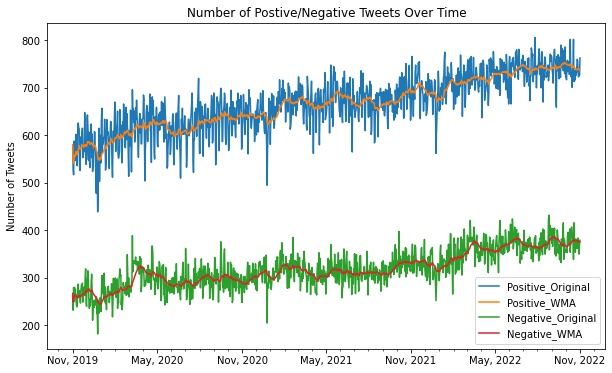

In [28]:
overall_series = df_to_timeseries(overall_df)
#Calculating a Weighted Moving Average and plot
wma_plot(series = overall_series, wd_size = 30, sentiment1 = 'positive', sentiment2 = 'negative')

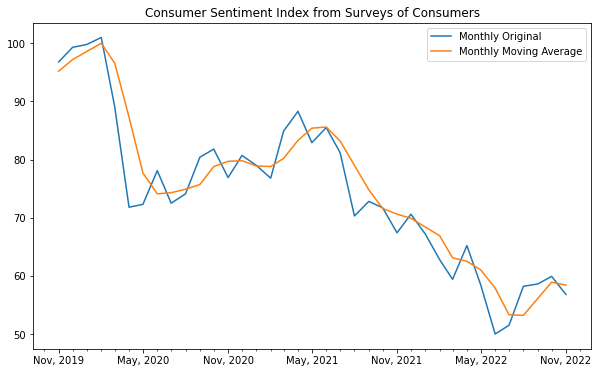

In [29]:
# Consumer sentiments index from nationally representative surveys: Surveys of Consumers 
survey_index_plot(consumer_sentiment_index, "Consumer Sentiment")

## 4. Consumers' Expectation for the Inflation(Price Changes)

### 4.1 What are the consumers' expectation regarding price going up or down?

In [30]:
def match_df(df, ngram):
    match_df = df.replace('price','prices', regex=True)
    match_df = df.replace('ll','will', regex=True)
    match_df['date'] = pd.to_datetime(match_df['date']).dt.date
    match_df = match_df.drop(['id', 'username','text'], axis=1)
    match_df = pd.DataFrame(match_df.loc[df.clean_text.apply(lambda x: any(k for k in ngram if k in x))])
    return match_df

def exptatction_classfier(df):
    """Extract the ngram about the expectation and direction

    Parameters
    ----------
    dataframe

    Returns
    -------
    dataframe with addtional variable 'expectation' and 'direction'
    """
    df['expectation'] = df.clean_text.str.extract('({})'.format('|'.join(ngram)), flags=re.IGNORECASE, expand=False).str.lower().fillna('')
    df['direction'] = np.where(df['expectation'].isin(up),'up','down')
    df = df.dropna()
    return df

def expectation_aggregate(df):
    expect_aggregate = df[['expectation','direction']].groupby(['expectation','direction']).size().reset_index()
    expect_aggregate = expect_aggregate.rename(columns={0: "count"})
    expect_aggregate['count'] = np.log(expect_aggregate['count'])
    expect_aggregate.loc[expect_aggregate['direction']=='down', 'count'] *= -1
    expect_aggregate.sort_values(by='count', ascending=False)
    expect_aggregate = expect_aggregate[1:]
    return expect_aggregate

In [31]:
up = ['price will increase','price will go up','higher price','will cost more','more expensive', 'will raise price','price climbing','price rising','will inflate']
down = ['price will decrease', 'price will go down', 'lower price','will cost less','cheaper','will reduce price','price dropping','price declining','price falling']
ngram = up + down

In [32]:
matched_classfied_df = exptatction_classfier(match_df(overall_df, ngram))
expectation_aggregate_df = expectation_aggregate(matched_classfied_df)
expectation_aggregate_df.head()

,expectation,direction,count
1,cheaper,down,-10.942208
2,higher price,up,10.602493
3,lower price,down,-8.792398
4,more expensive,up,2.995732
5,price climbing,up,2.708050


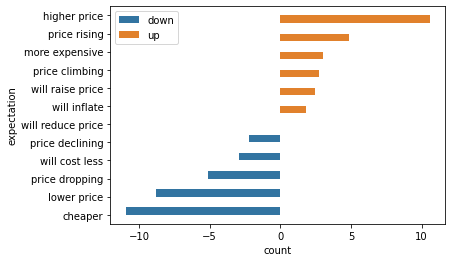

In [33]:
plot_order = expectation_aggregate_df.groupby('expectation')['count'].sum().sort_values(ascending=False).index.values
colors = expectation_aggregate_df['direction']
sns.barplot(y = expectation_aggregate_df['expectation'], x = expectation_aggregate_df['count'], hue = colors,palette = sns.color_palette(),order = plot_order)
plt.gca().legend().set_title('')

### 4.2 How do these expectations changing overtime?

In [34]:
def add_price_cat(matched_classfied_df, price_cat):
    matched_classfied_cat_df = pd.DataFrame(matched_classfied_df.loc[matched_classfied_df.clean_text.apply(lambda x: any(k for k in price_cat if k in x))])
    matched_classfied_cat_df['category'] =matched_classfied_cat_df.clean_text.str.extract('({})'.format('|'.join(price_cat)), flags=re.IGNORECASE, expand=False).str.lower().fillna('')
    matched_classfied_df['category']= 'others'
    df_diff = matched_classfied_df[~matched_classfied_df.clean_text.isin(matched_classfied_cat_df.clean_text)]
    df_full = pd.concat([matched_classfied_cat_df, df_diff], ignore_index=True)
    return df_full

def df_to_fourseries(df):
    #df['count'] = np.log(df['count'])
    df1 = df[df['category']=='food']
    df2 = df[df['category']=='gas']
    df3 = df[df['category']=='rent']
    df4 = df[df['category']=='others']
    series1 = (pd.pivot(df1, index=['direction'], columns = 'date',values = 'count')).squeeze() #Reshape from long to wide
    series2 = (pd.pivot(df2, index=['direction'], columns = 'date',values = 'count')).squeeze() 
    series3 = (pd.pivot(df3, index=['direction'], columns = 'date',values = 'count')).squeeze()
    series4 = (pd.pivot(df4, index=['direction'], columns = 'date',values = 'count')).squeeze()
    list_of_series = [series1,series2,series3,series4]
    return list_of_series

def simple_plot(df):
    #df['count'] = np.log(df['count'])
    df1 = df[df['category']=='food']
    df2 = df[df['category']=='gas']
    df3 = df[df['category']=='rent']
    df4 = df[df['category']=='others']
    fig, ax = plt.subplots(figsize=(10, 6))
    month_year_formatter = mdates.DateFormatter('%b, %Y')
    half_year_locator = mdates.MonthLocator(interval=6)
    monthly_locator = mdates.MonthLocator()
    ax.xaxis.set_major_locator(half_year_locator)
    ax.xaxis.set_minor_locator(monthly_locator)
    ax.xaxis.set_major_formatter(month_year_formatter)
    ax.plot(df1['date'], df1['count'],label = 'food')
    ax.plot(df2['date'], df2['count'],label = 'gas')
    ax.plot(df3['date'], df3['count'],label = 'rent')
    #ax.plot(df3['date'], df3['count'],label = 'others')
    #ax.set_xlabel("Time")
    #ax.set_ylabel("Number of Tweet")
    ax.legend()
    ax.set_title("Original Time Series")
    
def wma_index_plot(df, wd_size):
    #df['count'] = np.log(df['count'])
    series1 = df_to_fourseries(df)[0]
    series2 = df_to_fourseries(df)[1]
    series3 = df_to_fourseries(df)[2]
    series4 = df_to_fourseries(df)[3]
    weights = np.arange(1, wd_size + 1).astype(float) # linear weighting
    wma1 = []
    for i in range(len(series1)): # loop through case counts
        low, high = max(0, i - wd_size + 1), i + 1 # get current window
        wma1.append(np.average(series1.iloc[low: high], weights=weights[-(high - low):])) # compute average
    wma2 = []
    for i in range(len(series2)): # loop through case counts
        low, high = max(0, i - wd_size + 1), i + 1 # get current window
        wma2.append(np.average(series2.iloc[low: high], weights=weights[-(high - low):])) # compute average
    wma3 = []
    for i in range(len(series3)): # loop through case counts
        low, high = max(0, i - wd_size + 1), i + 1 # get current window
        wma3.append(np.average(series3.iloc[low: high], weights=weights[-(high - low):])) # compute average
    wma4 = []
    for i in range(len(series4)): # loop through case counts
        low, high = max(0, i - wd_size + 1), i + 1 # get current window
        wma4.append(np.average(series4.iloc[low: high], weights=weights[-(high - low):])) # compute average
    wma1 = np.array(wma1) # convert to an array
    wma2 = np.array(wma2)
    wma3 = np.array(wma3)
    wma4 = np.array(wma4)
    # plot
    fig, ax = plt.subplots(figsize=(10, 6))
    month_year_formatter = mdates.DateFormatter('%b, %Y')
    half_year_locator = mdates.MonthLocator(interval=6)
    monthly_locator = mdates.MonthLocator()
    ax.xaxis.set_major_locator(half_year_locator)
    ax.xaxis.set_minor_locator(monthly_locator)
    ax.xaxis.set_major_formatter(month_year_formatter)
    ax.plot(series1.index, wma1, label = "Food")
    ax.plot(series2.index, wma2, label = "Gas")
    ax.plot(series3.index, wma3, label = "Rent")
    #ax.plot(series4.index, wma4, label = "Others")
    #ax.set_xlabel("Time")
    #ax.set_ylabel("Number of Tweet")
    ax.legend()
    ax.set_title("Index DOWN: Weighted Moving Average (WMA)")
    
def ema_index_plot(df, lmbd):
    df['date'] = pd.to_datetime(df['date']).dt.date
    series1 = df_to_fourseries(df)[0]
    series2 = df_to_fourseries(df)[1]
    series3 = df_to_fourseries(df)[2]
    series4 = df_to_fourseries(df)[3]
    time_diff1 = (series1.index.to_series() - series1.index[0]).apply(lambda x: x.days).to_numpy()
    time_ema1 = []
    for i in range(len(series1)): # loop through case counts
        weights = np.exp(-lmbd * time_diff1[i::-1]) # compute weights
        time_ema1.append(np.average(series1.iloc[: i + 1], weights=weights)) # calculate average
    time_ema1 = np.array(time_ema1) # convert results to an array
    time_diff2 = (series2.index.to_series() - series2.index[0]).apply(lambda x: x.days).to_numpy()
    time_ema2 = []
    for i in range(len(series2)): # loop through case counts
        weights = np.exp(-lmbd * time_diff2[i::-1]) # compute weights
        time_ema2.append(np.average(series2.iloc[: i + 1], weights=weights)) # calculate average
    time_ema2 = np.array(time_ema2) # convert results to an array
    time_diff3 = (series3.index.to_series() - series3.index[0]).apply(lambda x: x.days).to_numpy()
    time_ema3 = []
    for i in range(len(series3)): # loop through case counts
        weights = np.exp(-lmbd * time_diff3[i::-1]) # compute weights
        time_ema3.append(np.average(series3.iloc[: i + 1], weights=weights)) # calculate average
    time_ema3 = np.array(time_ema3) # convert results to an array
    time_diff4 = (series4.index.to_series() - series4.index[0]).apply(lambda x: x.days).to_numpy()
    time_ema4 = []
    for i in range(len(series4)): # loop through case counts
        weights = np.exp(-lmbd * time_diff4[i::-1]) # compute weights
        time_ema4.append(np.average(series4.iloc[: i + 1], weights=weights)) # calculate average
    time_ema4 = np.array(time_ema4) # convert results to an array
    #Plot
    fig, ax = plt.subplots(figsize=(10, 6))
    month_year_formatter = mdates.DateFormatter('%b, %Y')
    half_year_locator = mdates.MonthLocator(interval=6)
    monthly_locator = mdates.MonthLocator()
    ax.xaxis.set_major_locator(half_year_locator)
    ax.xaxis.set_minor_locator(monthly_locator)
    ax.xaxis.set_major_formatter(month_year_formatter)
    ax.plot(series1.index, time_ema1, label = "Food")
    ax.plot(series2.index, time_ema2, label = "Gas")
    ax.plot(series3.index, time_ema3, label = "Rent")
    #ax.plot(series4.index, time_ema4, label = "Others")
    #ax.set_xlabel("Time")
    #ax.set_ylabel("Number of Tweet")
    ax.set_title("Exponential Moving Average (EMA)")

In [35]:
price_cat = ['food', 'gas', 'rent', 'others']
matched_classfied_df = add_price_cat(matched_classfied_df, price_cat)
expect_timeseries_df = matched_classfied_df[['date','direction','category']].groupby(['date','direction','category']).size().reset_index().rename(columns={0: "count"})
expect_timeseries_df.head()

,date,direction,category,count
0,2019-11-01,down,food,2
1,2019-11-01,down,gas,6
2,2019-11-01,down,others,33
3,2019-11-01,down,rent,2
4,2019-11-01,up,gas,1


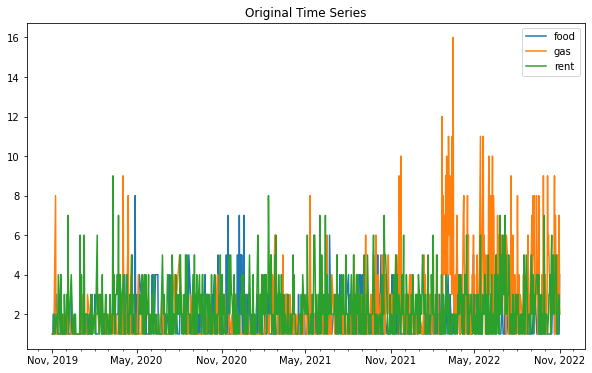

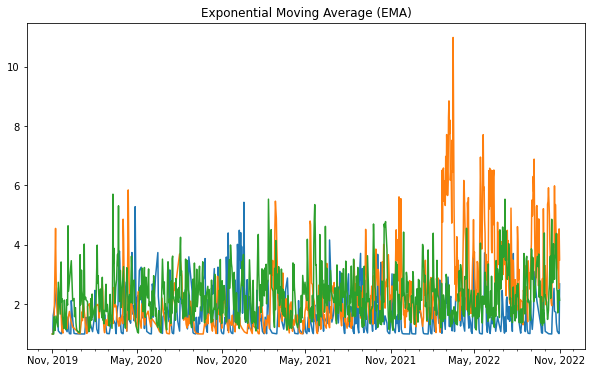

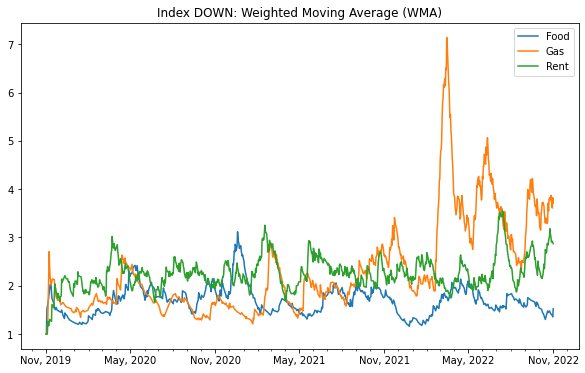

In [36]:
up_timeseries_df = expect_timeseries_df[expect_timeseries_df['direction']=='up']
# original plot
simple_plot(up_timeseries_df)
# EMA
ema_index_plot(up_timeseries_df, lmbd = 0.5)
# WMA
wma_index_plot(up_timeseries_df, wd_size = 30)

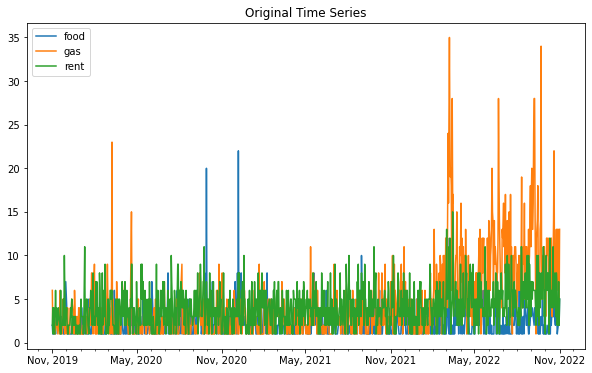

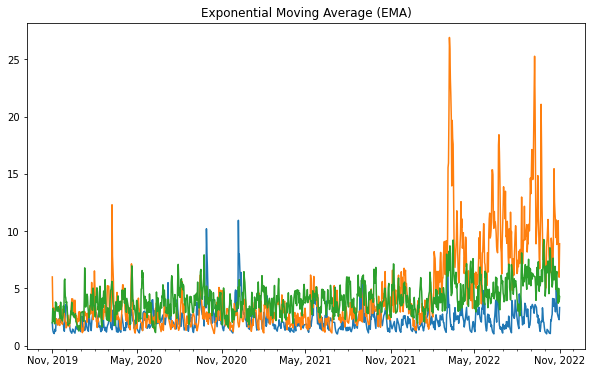

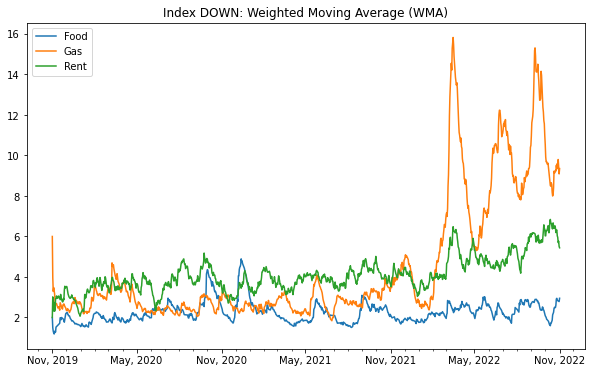

In [37]:
down_timeseries_df = expect_timeseries_df[expect_timeseries_df['direction']=='down']
# original plot
simple_plot(down_timeseries_df)
#EMA
ema_index_plot(down_timeseries_df, lmbd = 0.5)
# WMA
wma_index_plot(down_timeseries_df, wd_size = 30)

## 5. Predicting the Inflation/Price Changes

In [38]:
def expect_index(df):
    df.loc[df['direction']== 'up', 'direction_num'] = 1
    df.loc[df['direction']== 'down', 'direction_num'] = -1
    df['expect_index'] = df['direction_num']* df['count']
    return df

In [39]:
# Creat a single index, combining up and down index
df = (expect_index(expect_timeseries_df)[['expect_index','date']].groupby(['date']).size().reset_index().rename(columns={0: "count"})).set_index('date')['count']

In [40]:
# extract the timestamps as a pandas Series
time_stamps = df.index.to_series() # convert indexes to Series
print(time_stamps)
# construct an array of the timestamps - each will be incremented by 0.01 since we are dividing by 100
train_X = (time_stamps - time_stamps.iloc[0]).apply(lambda x: x.days).to_numpy() / 100
train_X
# create an array of the daily new case counts
train_y = df.to_numpy()
train_y
# fit a 10th order polynomial to the time series
train_X_poly = PolynomialFeatures(12).fit_transform(train_X.reshape(-1, 1))
lin_reg = LinearRegression().fit(train_X_poly, train_y.reshape(-1))

date
2019-11-01    2019-11-01
2019-11-02    2019-11-02
2019-11-03    2019-11-03
2019-11-04    2019-11-04
2019-11-05    2019-11-05
                 ...    
2022-10-28    2022-10-28
2022-10-29    2022-10-29
2022-10-30    2022-10-30
2022-10-31    2022-10-31
2022-11-01    2022-11-01
Name: date, Length: 1097, dtype: object


In [41]:
# make predictions
case_preds = lin_reg.predict(train_X_poly)
# assess predictions
r2_score(train_y, case_preds)

0.14148431042539045

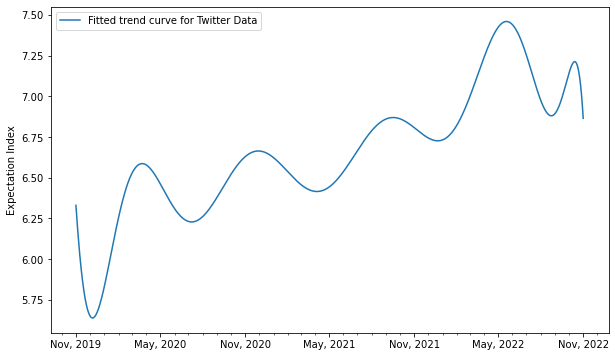

In [42]:
# let's see the regression line
survey_index_series1 = price_expchange_index.set_index('Date')['Monthly']
survey_index_series2 = price_expchange_index.set_index('Date')['Monthly_MA']
fig, ax = plt.subplots(figsize=(10, 6))
month_year_formatter = mdates.DateFormatter('%b, %Y')
half_year_locator = mdates.MonthLocator(interval=6)
monthly_locator = mdates.MonthLocator()
ax.xaxis.set_major_locator(half_year_locator)
ax.xaxis.set_minor_locator(monthly_locator)
ax.xaxis.set_major_formatter(month_year_formatter)
ax.plot(df.index, case_preds, label="Fitted trend curve for Twitter Data")
ax.set_ylabel("Expectation Index")
ax.legend()

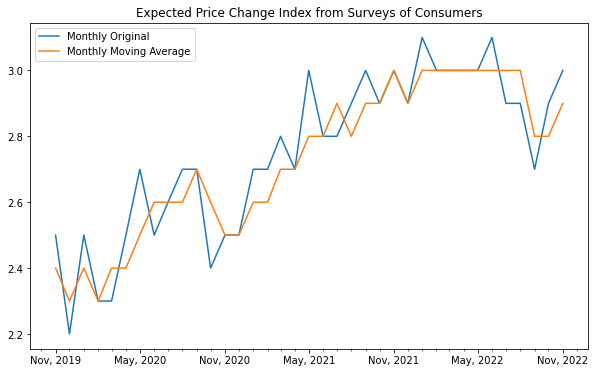

In [43]:
# Consumer sentiments index from nationally representative surveys: Surveys of Consumers 
survey_index_plot(price_expchange_index, "Expected Price Change")

In [44]:
# We would like combine the above two graph into one

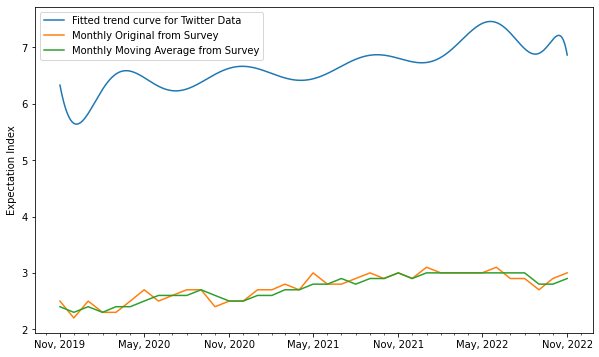

In [45]:
survey_index_series1 = price_expchange_index.set_index('Date')['Monthly']
survey_index_series2 = price_expchange_index.set_index('Date')['Monthly_MA']
fig, ax = plt.subplots(figsize=(10, 6))
month_year_formatter = mdates.DateFormatter('%b, %Y')
half_year_locator = mdates.MonthLocator(interval=6)
monthly_locator = mdates.MonthLocator()
ax.xaxis.set_major_locator(half_year_locator)
ax.xaxis.set_minor_locator(monthly_locator)
ax.xaxis.set_major_formatter(month_year_formatter)
ax.plot(df.index, case_preds, label="Fitted trend curve for Twitter Data")
ax.plot(survey_index_series1.index, survey_index_series1.values, label = "Monthly Original from Survey")
ax.plot(survey_index_series2.index, survey_index_series2.values, label = "Monthly Moving Average from Survey")
ax.set_ylabel("Expectation Index")
ax.legend()

In [46]:
future_date = pd.read_csv('future_date.csv')
future_date['date'] = pd.to_datetime(future_date['date']).dt.date
time_stamps = future_date.date # convert indexes to Series
print(time_stamps)
# construct an array of the timestamps - each will be incremented by 0.01 since we are dividing by 100
test_X = (time_stamps - time_stamps.iloc[0]).apply(lambda x: x.days).to_numpy() / 100
# fit a 10th order polynomial to the time series
test_X_poly = PolynomialFeatures(12).fit_transform(test_X.reshape(-1, 1))
pred = lin_reg.predict(test_X_poly)

0      2022-11-01
1      2022-11-02
2      2022-11-03
3      2022-11-04
4      2022-11-05
          ...    
361    2023-10-28
362    2023-10-29
363    2023-10-30
364    2023-10-31
365    2023-11-01
Name: date, Length: 366, dtype: object


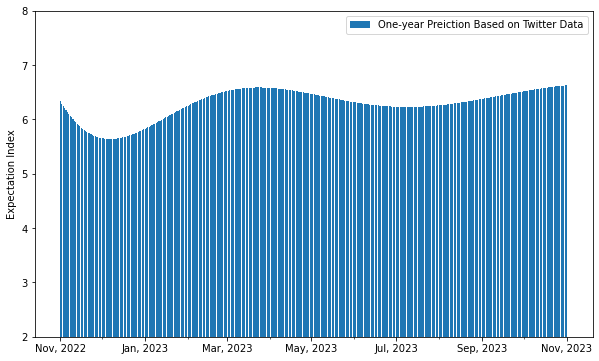

In [47]:
fig, ax = plt.subplots(figsize=(10, 6))
month_year_formatter = mdates.DateFormatter('%b, %Y')
half_year_locator = mdates.MonthLocator(interval=2)
monthly_locator = mdates.MonthLocator()
ax.xaxis.set_major_locator(half_year_locator)
ax.xaxis.set_minor_locator(monthly_locator)
ax.xaxis.set_major_formatter(month_year_formatter)
ax.bar(time_stamps, pred, label="One-year Preiction Based on Twitter Data")
ax.set_ylabel("Expectation Index")
plt.ylim([2, 8])
ax.legend()